In [2]:
import xarray as xr
import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean


In [3]:
fp = "./sample_data/r2t_train/20180607T184326_dmi_prep.nc"
data = xr.open_dataset(fp)
data

<xarray.Dataset>
Dimensions:               (sar_lines: 4999, sar_samples: 5213,
                           sar_sample_2dgrid_points: 21,
                           sar_line_2dgrid_points: 21, 2km_grid_lines: 199,
                           2km_grid_samples: 208)
Dimensions without coordinates: sar_lines, sar_samples,
                                sar_sample_2dgrid_points,
                                sar_line_2dgrid_points, 2km_grid_lines,
                                2km_grid_samples
Data variables: (12/29)
    SIC                   (sar_lines, sar_samples) uint8 ...
    SOD                   (sar_lines, sar_samples) uint8 ...
    FLOE                  (sar_lines, sar_samples) uint8 ...
    sar_grid2d_latitude   (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    sar_grid2d_longitude  (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    nersc_sar_primary     (sar_lines, sar_samples) float32 ...
    ...                    ...
    u10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 ...
    v10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 ...
    t2m                   (2km_grid_lines, 2km_grid_samples) float32 ...
    skt                   (2km_grid_lines, 2km_grid_samples) float32 ...
    tcwv                  (2km_grid_lines, 2km_grid_samples) float32 ...
    tclw                  (2km_grid_lines, 2km_grid_samples) float32 ...
Attributes:
    scene_id:       20180607T184326_dmi_prep.nc
    original_id:    S1B_EW_GRDM_1SDH_20180607T184326_20180607T184426_011271_0...
    ice_service:    dmi
    flip:           0
    pixel_spacing:  80

In [4]:
HH = data.nersc_sar_primary
HV = data.nersc_sar_secondary
IA = data.sar_incidenceangle
HH_masked = HH.where(HH != 0)
HV_masked = HV.where(HV != 0)
IA_masked = IA.where(IA != 0)
img_mask = HH.where(HH == 0)

grid_lats = data.sar_grid2d_latitude
grid_lons = data.sar_grid2d_longitude

SIC = data.SIC
SOD = data.SOD
FLOE = data.FLOE
sod_masked = SOD.where(SOD != 255)
sic_masked = SIC.where(SIC != 255)
floe_masked = FLOE.where(FLOE != 255)
label_mask = SOD.where(SOD == 255)

In [5]:
assert HH.shape == HV.shape == IA.shape
print(f"Image dims (h, w): {HH.shape}")

assert grid_lats.shape == grid_lons.shape
print(f"Lat/Lon grid dims (h, w): {grid_lats.shape}")

assert SIC.shape == SOD.shape == FLOE.shape
print(f"Label dims (h, w): {SIC.shape}")

Image dims (h, w): (4999, 5213)
Lat/Lon grid dims (h, w): (21, 21)
Label dims (h, w): (4999, 5213)


Display imagery

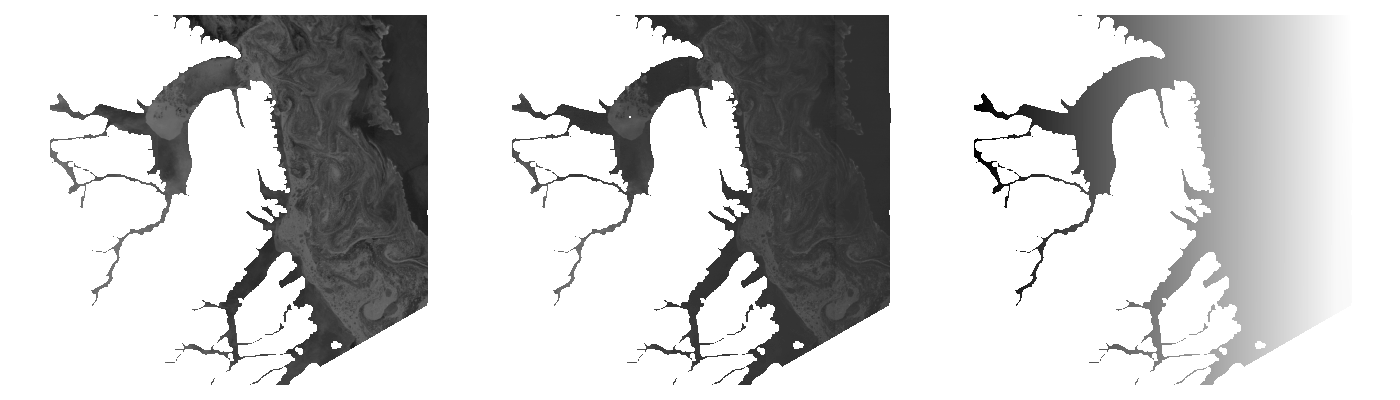

In [6]:
%matplotlib widget

fig, axs = plt.subplots(1, 3, figsize=(14, 4), frameon=False)
axs[0].imshow(HH_masked, cmap='gray')
axs[1].imshow(HV_masked, cmap='gray')
axs[2].imshow(IA_masked, cmap='gray')

for ax in axs:
    ax.axis('off')

fig.tight_layout()
plt.show()

Display labels

In [7]:
SOD_CLASSLABEL_LUT = {
    0: 'Ice Free',
    1: 'New',
    2: 'Young',
    3: 'Thin FY',
    4: 'Thick FY',
    5: 'Old',
    # 255: 'Glacier/NaN'
}
SIC_CLASSLABEL_LUT = {
    0: 'Ice Free',
    1: '1/10',
    2: '2/10',
    3: '3/10',
    4: '4/10',
    5: '5/10', 
    6: '6/10',
    7: '7/10', 
    8: '8/10',
    9: '9/10',
    10: '10/10',
    # 255: 'NaN'
}
FLOE_CLASSLABEL_LUT = {
    0: 'Ice Free',
    1: 'Ice Cake',
    2: 'Small Floe',
    3: 'Medium Floe',
    4: 'Big Floe',
    5: 'Vast/Giant Floe',
    6: 'Berg Ice',
    # 255: 'Pancake/Fast/NaN'
}

In [8]:
print(f"SOD values: {np.unique(SOD).tolist()}")
print(f"SIC values: {np.unique(SIC).tolist()}")
print(f"FLOE values: {np.unique(FLOE).tolist()}")

SOD values: [0, 4, 255]
SIC values: [0, 3, 5, 6, 8, 10, 255]
FLOE values: [0, 1, 3, 4, 5, 255]


In [28]:
def plot_sic(sic_data, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # Set up discrete colormap for labels
    boundaries = []
    sic_keys = list(SIC_CLASSLABEL_LUT.keys())
    for sic_key in sic_keys:
        boundaries.append(sic_key-0.5)
    boundaries.append(sic_keys[-1]+0.5)
    assert len(boundaries) == len(sic_keys) + 1

    cmap = cmocean.cm.ice
    cmap.set_bad('grey')
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=cmap.N)

    sic_tick_formatter = mpl.ticker.FuncFormatter(lambda val, loc: SIC_CLASSLABEL_LUT[val])

    im = ax.imshow(sic_data, norm=norm, cmap=cmap)
    fig.colorbar(im, cax=cax, ticks=[0, 2, 4, 6, 8, 10], format=sic_tick_formatter)
    ax.set_title("SIC")


def plot_sod(sod_data, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # Set up discrete colormap for labels
    boundaries = []
    sod_keys = list(SOD_CLASSLABEL_LUT.keys())
    for sod_key in sod_keys:
        boundaries.append(sod_key-0.5)
    boundaries.append(sod_keys[-1]+0.5)
    assert len(boundaries) == len(sod_keys) + 1

    # cmap = cmocean.cm.thermal
    cmap = mpl.colormaps['gist_earth']
    cmap.set_bad('grey')
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=cmap.N)

    sod_tick_formatter = mpl.ticker.FuncFormatter(lambda val, loc: SOD_CLASSLABEL_LUT[val])

    im = ax.imshow(sod_data, norm=norm, cmap=cmap)
    fig.colorbar(im, cax=cax, ticks=[0, 1, 2, 3, 4, 5], format=sod_tick_formatter)
    ax.set_title("SOD")


def plot_floe(floe_data, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # Set up discrete colormap for labels
    boundaries = []
    floe_keys = list(FLOE_CLASSLABEL_LUT.keys())
    for floe_key in floe_keys:
        boundaries.append(floe_key-0.5)
    boundaries.append(floe_keys[-1]+0.5)
    assert len(boundaries) == len(floe_keys) + 1

    cmap = cmocean.cm.deep
    cmap = cmap.reversed()
    cmap.set_bad('grey')
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=cmap.N)

    floe_tick_formatter = mpl.ticker.FuncFormatter(lambda val, loc: FLOE_CLASSLABEL_LUT[val])

    im = ax.imshow(floe_data, norm=norm, cmap=cmap)
    fig.colorbar(im, cax=cax, ticks=[0, 1, 2, 3, 4, 5, 6], format=floe_tick_formatter)
    ax.set_title("FLOE")


def plot_img_band(img_data, ax):
    cmap = plt.get_cmap('gray')
    cmap.set_bad('grey')
    ax.imshow(img_data, cmap=cmap)


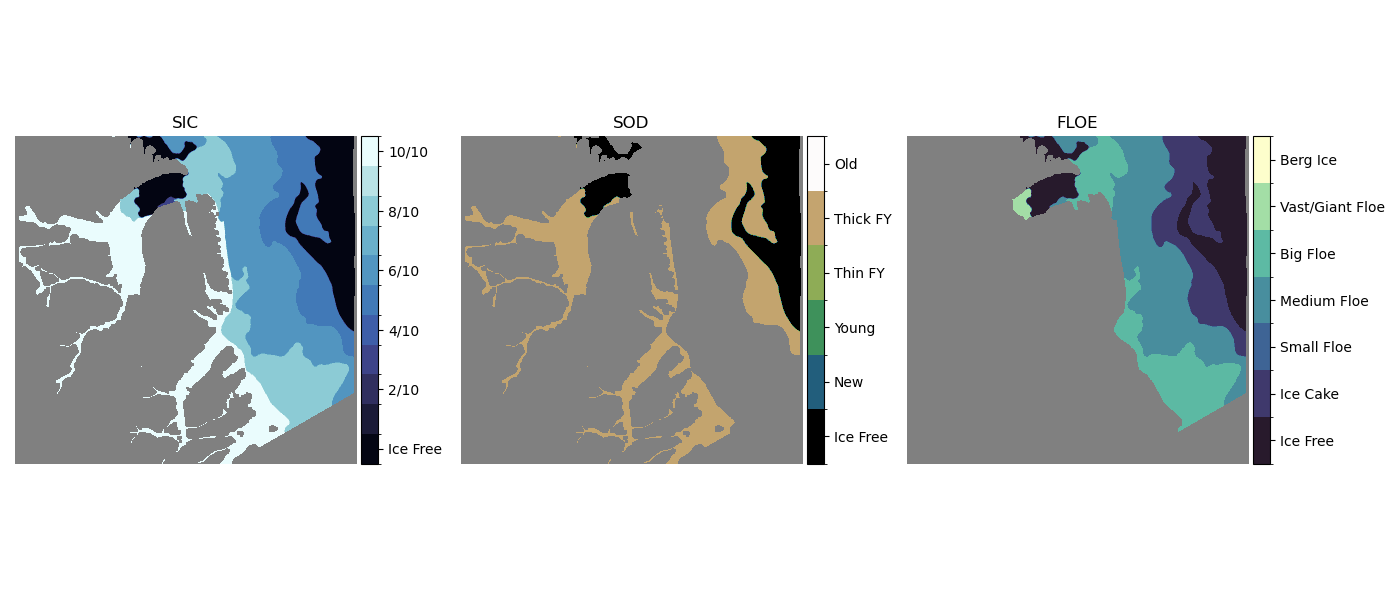

In [29]:
%matplotlib widget

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

plot_sic(sic_masked, fig, axs[0])
plot_sod(sod_masked, fig, axs[1])
plot_floe(floe_masked, fig, axs[2])

for ax in axs:
    ax.axis('off')

fig.tight_layout()
plt.show()

All together now

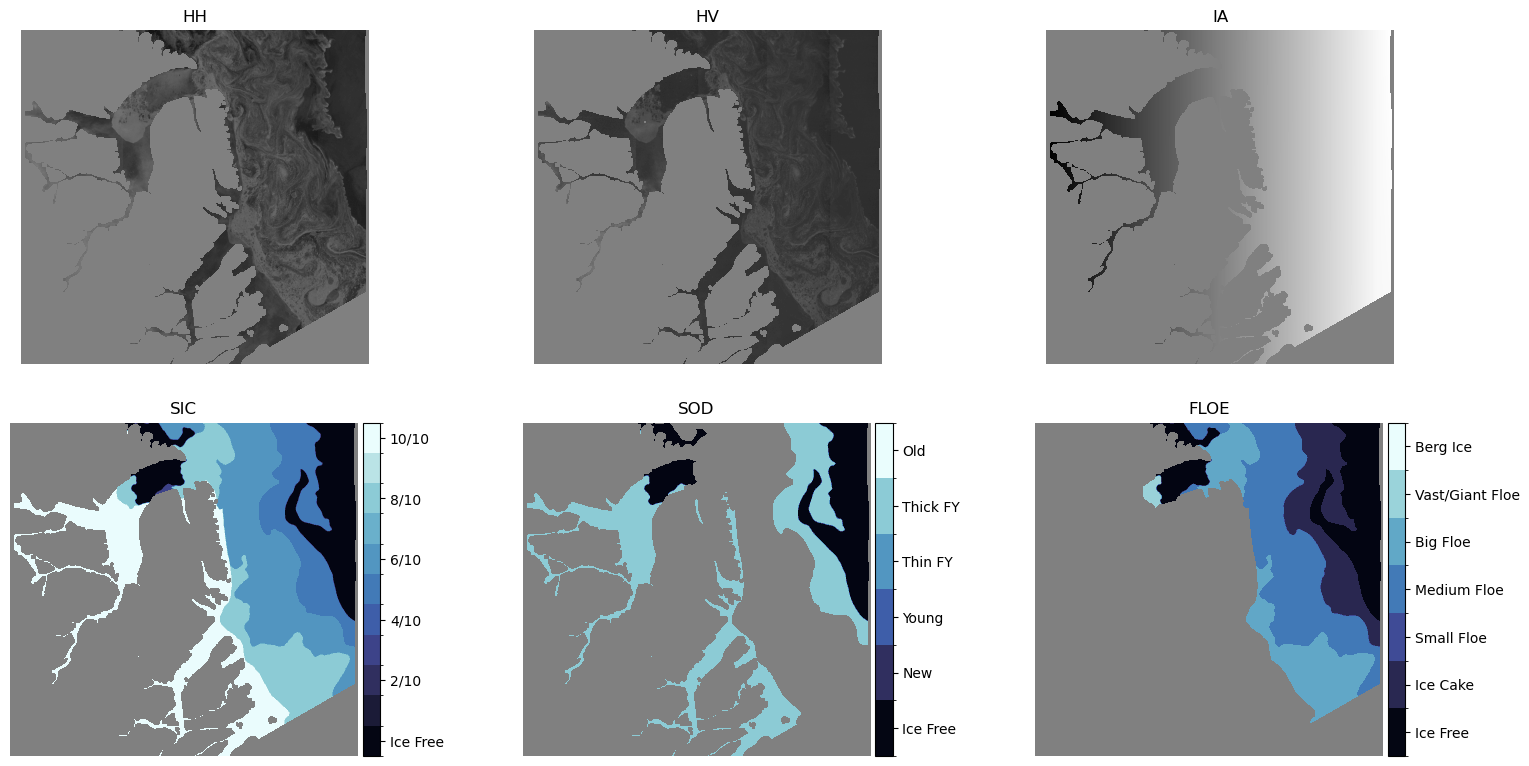

In [12]:
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

plot_img_band(HH_masked, axs[0, 0])
axs[0, 0].set_title("HH")
plot_img_band(HV_masked, axs[0, 1])
axs[0, 1].set_title("HV")
plot_img_band(IA_masked, axs[0, 2])
axs[0, 2].set_title("IA")

plot_sic(sic_masked, fig, axs[1, 0])
plot_sod(sod_masked, fig, axs[1, 1])
plot_floe(floe_masked, fig, axs[1, 2])

fig.tight_layout()
for r in axs:
    for ax in r:
        ax.axis('off')

plt.show()